In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
DATA_PATH_ORIG = r'../data/scenario_10.csv'

In [3]:
data_df = pd.read_csv(DATA_PATH_ORIG, parse_dates=['start_date'])

In [4]:
data_df.shape

(5180851, 13)

In [5]:
data_df.label.unique()

array(['Background', 'LEGITIMATE', 'Botnet'], dtype=object)

Let's look at the distribution of the labels in the dataset

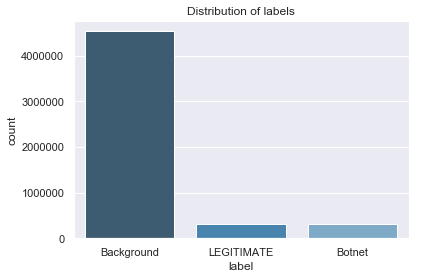

In [6]:
sns.countplot(x="label", data=data_df, palette="Blues_d")
plt.title("Distribution of labels")
plt.show()

We can see that there is a high imbalance, if we consider the background data

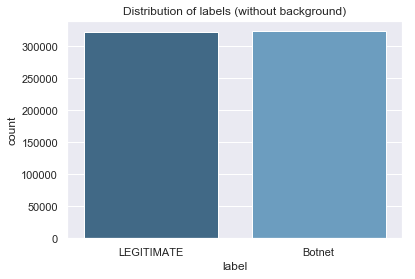

In [7]:
sns.countplot(x="label", data=data_df[data_df['label'] != 'Background'], palette="Blues_d")
plt.title("Distribution of labels (without background)")
plt.show()

Between Legitimate and Botnet there is a nice balance

# Attention: for now, I removed background information. Let's see what they see on Mattermost

In [8]:
data_df = data_df[data_df['label'] != 'Background']
data_df.reset_index(drop=True, inplace=True)
data_df.shape

(645358, 13)

In [9]:
data_df.dtypes

start_date    datetime64[ns]
duration             float64
protocol              object
src_addr              object
dst_addr              object
flags                 object
tos                    int64
packets                int64
bytes                  int64
flows                  int64
label                 object
src_port               int64
dst_port               int64
dtype: object

Let's drop some columns which we do not use for the classification (we do not consider sequences)

In [10]:
new_df = data_df.drop(columns=['start_date', 'src_addr', 'dst_addr', 'tos', 'packets', 'flows'])
new_df.head()

,duration,protocol,flags,bytes,label,src_port,dst_port
0,4.985,TCP,PA_,86277,LEGITIMATE,80,56949
1,0.000,TCP,A_,66,LEGITIMATE,48102,443
2,4.921,TCP,A_,3234,LEGITIMATE,56949,80
3,4.742,TCP,A_,7080,LEGITIMATE,2768,80
4,0.000,TCP,A_,60,LEGITIMATE,56058,443


In [11]:
labels = data_df.label.map({
    'LEGITIMATE': 0,
    'Botnet': 1
})

### Let's do some analysis to select which features to use

In [ ]:
categorical = ['protocol', 'flags', 'src_port', 'dst_port']
for feature in new_df.columns:
    if feature == 'label':
        continue
        
    print(f"Processing feature '{feature}'")
    botnet = new_df[new_df.label == 'Botnet']
    legitimate = new_df[new_df.label == 'LEGITIMATE']
    
    
    if feature not in categorical:  
        plt.figure(figsize=(17,6))
        sns.distplot(botnet[feature], color='Red', hist=False, label='Botnet')
        sns.distplot(legitimate[feature], color='Green', hist=False, label='Legitimate')
        plt.legend()
        plt.title(feature)
        plt.show()
        
    else:
        plt.figure(figsize=(17,6))
        sns.countplot(x=feature, data=botnet, palette="Blues_d", label='Botnet')
        plt.legend()
        plt.title(feature)
        plt.show()
        
        plt.figure(figsize=(17,6))
        sns.countplot(x=feature, data=legitimate, palette="Greens_d", label='Legitimate')
        plt.legend()
        plt.title(feature)
        plt.show()
        

    

first of all, let's one-hot encode the categorical features